In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

## Funciones

### M-QAM Modulator - Demodulator

In [22]:
def modulator(data: np.array, M: int) -> np.array:
	"""
	Modulate the input data using M-QAM modulation.
	Parameters:
		data: np.array
			The input data to be modulated.
		M: int
			The order of the modulation.
	Returns:
		S: np.array
			The modulated data.
	"""
	# Constants
	sqrt_M = np.sqrt(M).astype(int)
	k = np.log2(M).astype(int)

	# Binary to Gray code constelation convertor
	vect = np.array(range(sqrt_M))

	# Gray code constelation to symbols convertor
	vect = np.arange(1, np.sqrt(M), 2)
	symbols = np.concatenate((np.flip(-vect, axis=0), vect)).astype(int)

	# Modulation
	data_input = data.reshape((-1,k))
	I = np.zeros((data_input.shape[0],))
	Q = np.zeros((data_input.shape[0],))
	for n in range(int(data_input.shape[1] / 2)):
		I = I + data_input[:,n] * 2 ** n
	for n in range(int(data_input.shape[1]/2),int(data_input.shape[1])):
		Q = Q + data_input[:,n] * 2 ** (n - int(data_input.shape[1]/2))

	I = I.astype(int)
	Q = Q.astype(int)

	I = symbols[I]
	Q = symbols[Q]

	S = I + 1j * Q

	return S

def demodulator(S: np.array, M: int) -> np.array:
	"""
	Demodulate the input data using M-QAM modulation.
	Parameters:
		S: np.array
			The input data to be demodulated.
		M: int
			The order of the modulation.
	Returns:	
		data_bits: np.array
			The demodulated data.
	"""
	sqrt_M = int(np.sqrt(M))
	k = int(np.log2(M))
	k_half = k // 2
    
    # Binary to Gray code constelation convertor
	vect = np.arange(1, sqrt_M, 2)
	symbols = np.concatenate((np.flip(-vect), vect)).astype(int)
    
    # Demodulation
	I = np.real(S)
	Q = np.imag(S)
    
    # Find the closest symbol
	I_indices = np.array([np.argmin(np.abs(symbols - i)) for i in I])
	Q_indices = np.array([np.argmin(np.abs(symbols - q)) for q in Q])
    
    # Convert the indices to binary
	I_bits = ((I_indices[:, None] & (1 << np.arange(k_half))) > 0).astype(int)
	Q_bits = ((Q_indices[:, None] & (1 << np.arange(k_half))) > 0).astype(int)
    
	data_bits = np.hstack((I_bits, Q_bits))
    
	return data_bits.flatten()


### FFT/IFFT

In [23]:
def fft(a: np.array , inv: bool = False) -> None:
    """
    Compute the Fast Fourier Transform of the input array.
    Parameters:
        a: np.array
            The input array to be transformed.
        inv: bool
            If True, compute the inverse FFT.
    """

    N = len(a)
    assert (N & (N - 1)) == 0  # N must be a power of 2
    k = 0
    b = 0

    # Bit reversal
    for i in range(1, N):
        b = N >> 1
        while k & b:
            k ^= b
            b >>= 1
        k ^= b
        if i < k:
            a[i], a[k] = a[k], a[i]
    
    # Cooley-Tukey algorithm
    l = 2
    while l <= N:
        ang = 2 * np.pi / l * (1 if inv else -1)  
        wl = complex(np.cos(ang), np.sin(ang))
        for i in range(0, N, l):
            w = 1
            for j in range(l // 2):
                u = a[i + j]
                v = a[i + j + l // 2] * w
                a[i + j] = u + v
                a[i + j + l // 2] = u - v
                w *= wl
        l <<= 1
    
    # Scaling for inverse transform
    if inv:
        for i in range(N):
            a[i] /= N

### Image encoder

In [24]:
def imagen_grayscale_encoder(imagen_path: str):
    """
    Encode the input image to a binary array.
    Parameters:
        imagen_path: str
            The path to the image to be encoded.
    Returns:
        image_bits: np.array
            The binary array of the image.
        image: np.array
            The image.
    """
    image = cv2.imread(imagen_path, cv2.IMREAD_GRAYSCALE)
    image_bits = np.unpackbits(image) 

    return image_bits, image

### Add pilots

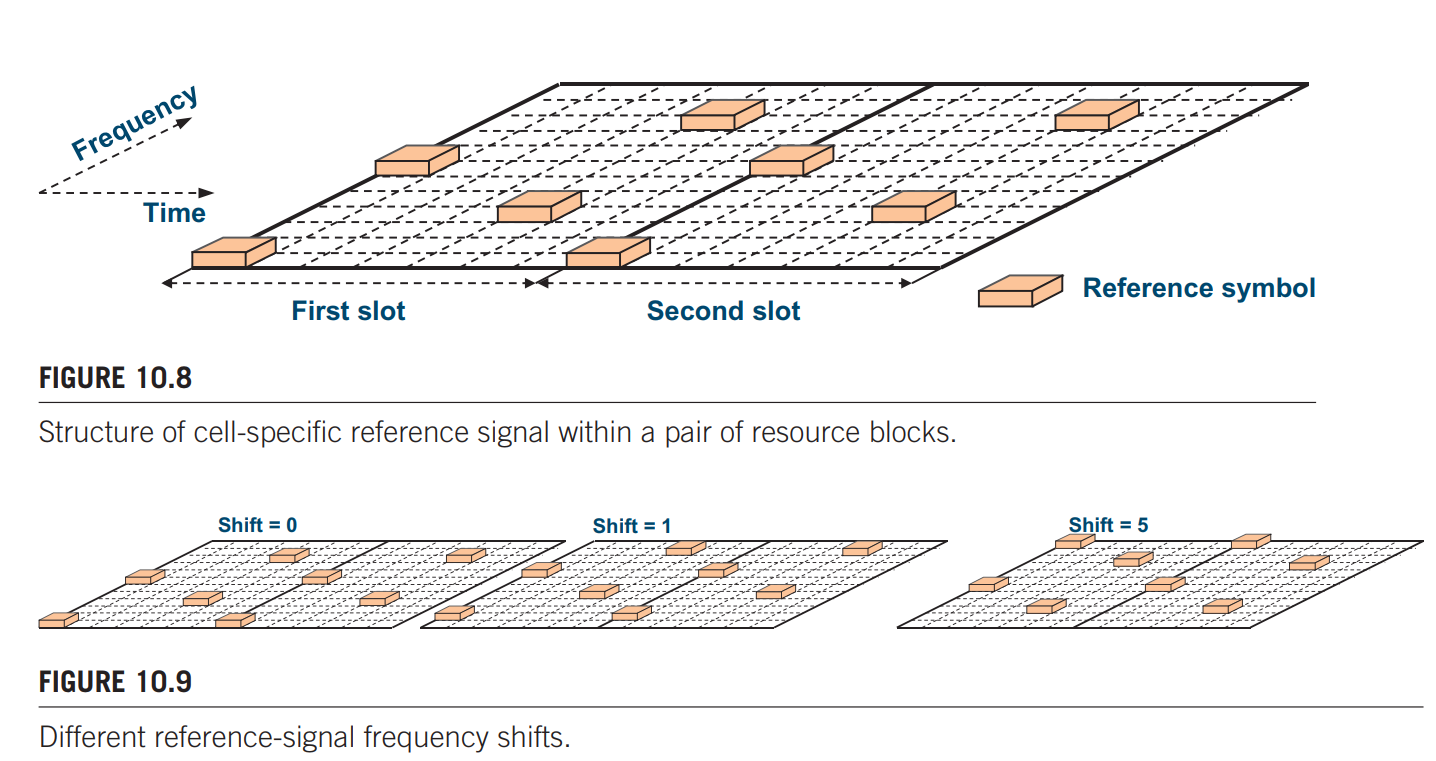

In [25]:
def generate_subcarriers(Nc: int, carry_pilot: bool, t_pilot: int, shift: int, pilot_value: complex) -> np.ndarray:
    """
    Generate the subcarriers for the OFDM modulation.
    Parameters:
        Nc: int
            The number of subcarriers.
        carry_pilot: bool
            If True, carry the pilot subcarriers.
        t_pilot: int
            The type of pilot subcarriers.
        shift: int
            The shift of the pilot subcarriers.
        pilot_value: complex
            The value of the pilot subcarriers.
    Returns:
        time_slot: np.array
            The time slot with the subcarriers.
    """
    
    if not carry_pilot:
        time_slot = np.array([0+0j]*Nc)
        return time_slot
    
    block = np.array([0+0j]*12)
    if t_pilot == 0:
        i1 = shift%12
        i2 = (shift+6)%12
    if t_pilot == 1:
        i1 = (shift+3)%12
        i2 = (shift+9)%12
        
    block[i1] = pilot_value
    block[i2] = pilot_value
    
    time_slot = np.tile(block, Nc//12)
    
    return time_slot
            

def fill_subcarriers_with_pilots(modulated_bits: np.array, Nc: int, pilot_value: complex) -> np.array:
    """
    Fill the subcarriers with the modulated bits.
    Parameters:
        modulated_bits: np.array
            The modulated bits.
        Nc: int
            The number of subcarriers.
        pilot_value: complex
            The value of the pilot subcarriers.
    Returns:
        filled_matrix: np.array
            The filled subcarriers.
        pilot_positions: np.array
            The positions of the pilot subcarriers.
    """

    t = 0
    shift = 0
    bit_index = 0
    filled_matrix = []
    pilot_positions = []  # Positions of the pilot subcarriers
    num_bits = len(modulated_bits)

    while bit_index < num_bits:
        carry_pilot = t == 0 or t == 4
        t_pilot = 0 if t == 0 else 1
        
        # Gen the subcarriers for this block
        time_slot = generate_subcarriers(Nc, carry_pilot, t_pilot, shift, pilot_value)
        
        # Get the positions of the pilot subcarriers
        pilot_indices = np.where(time_slot == pilot_value)[0]
        
        pilot_positions.append(pilot_indices)
        
        # Fill the subcarriers with the modulated bits
        for i in range(len(time_slot)):
            if bit_index >= num_bits:
                break
            if time_slot[i] == 0 + 0j:
                time_slot[i] = modulated_bits[bit_index]
                bit_index += 1
        
        # Append the time slot to the filled matrix
        filled_matrix.append(time_slot)
        
        t += 1
        if t == 7:
            t = 0
            shift += 1
    
    # Convert the lists to numpy arrays
    filled_matrix = np.array(filled_matrix)
    pilot_positions = np.array(pilot_positions, dtype=object) 
    
    return filled_matrix, pilot_positions

### Zero padding

In [26]:
def zeros_padding(arr: np.array, N: int, left_padding: int = 0) -> np.array:
    """
    Pad the input array with zeros to the desired length.
    Parameters:
        arr: np.array
            The input array to be padded.
        N: int
            The desired length of the array.
        left_padding: int
            The number of zeros to pad on the left side.  
    Returns:
        arr_padded: np.array
            The padded array.
    """
    right_padding = N - arr.shape[1] - left_padding
    arr_padded = np.pad(arr, pad_width=((0, 0), (left_padding, right_padding)), mode='constant', constant_values=0+0j)
    
    return arr_padded

### Cyclic-Prefix

In [27]:
def add_cp(x, Ncp):
    cp = x[:, -Ncp:]
    return np.concatenate((cp, x), axis=1)

def remove_cp(r_cp, Ncp):
    return r_cp[:, Ncp:]

### PAPR

In [28]:
def cal_papr(y: np.array) -> np.array:
    """
    Calculate the Peak-to-Average Power Ratio of the input signal.
    Parameters:
        y: np.array
            The input signal.  
    Returns:
        papr_values: np.array
            The PAPR values of the signal.
    """

    papr_values = []

    for i in range(y.shape[0]):
        fila_x_cp = y[i, :]
    
        potencia_pico = np.max(np.abs(fila_x_cp)**2)
        potencia_promedio = np.mean(np.abs(fila_x_cp)**2)
    
        papr = 10 * np.log10(potencia_pico / potencia_promedio)

        papr_values.append(papr)
    
    return np.array(papr_values).ravel()


### Channel response

In [29]:
def generate_channel_response(num_paths: int, los_ratio: float) -> np.ndarray:
    """
    Generate a channel response with a given number of paths and LoS ratio.
    Parameters:
        num_paths: int
            The number of paths.
        los_ratio: float
            The ratio of the power of the LoS component to the total power.
    Returns:
        channel_response: np.ndarray
            The generated channel response.
    """
    # Total power
    total_power = 1.0

    # Power assigned to LoS
    los_power = los_ratio * total_power

    # Power assigned to multipath components
    multipath_power = total_power - los_power

    # LoS component 
    los_component = np.sqrt(los_power)

    # Multipath components
    multipath_components = (np.sqrt(multipath_power / (num_paths - 1)) *
                            (np.random.randn(num_paths - 1) + 1j * np.random.randn(num_paths - 1)) / np.sqrt(2))

    # Combine LoS and multipath components
    channel_response = np.array([los_component] + list(multipath_components))
    
    return channel_response

### AWGN

$\text{SNR}_{\text{linear}} = 10^{\frac{\text{SNR}_{\text{dB}}}{10}}$

$P_{\text{signal}} = \frac{1}{N} \sum_{i=1}^{N} |x_i|^2$

$P_{\text{noise}} = \frac{P_{\text{signal}}}{\text{SNR}_{\text{linear}}}$

$n(t) = \sqrt{\frac{P_{\text{noise}}}{2}} \left( n_{\text{real}}(t) + j n_{\text{imag}}(t) \right)$

$y(t) = s(t) + n(t)$

In [30]:
def awgn(signal: np.array, snr_db: float) -> np.array:
    """ 
    Add AWGN to the input signal.
    Parameters:
        signal: np.array
            The input signal.
        snr_db: float
            The signal-to-noise ratio in dB.
    Returns:
        signal: np.array
            The signal with added noise.
    """
    snr_linear = 10 ** (snr_db / 10)
    noise_power = np.mean(np.abs(signal) ** 2) / snr_linear
    noise = np.sqrt(noise_power / 2) * (np.random.randn(*signal.shape) + 1j * np.random.randn(*signal.shape))
    return signal + noise

### Apply channel effect

In [31]:
def channel(y: np.array, h: np.array, snr_db: float) -> np.array:
    """
    Apply the channel response to the input signal.
    Parameters:
        y: np.array
            The input signal.
        h: np.array
            The channel response.
        snr_db: float
            The signal-to-noise ratio in dB.
    Returns:
        r: np.array
            The received signal.
    """
    r = np.zeros(y.shape, dtype=complex)

    for i in range(y.shape[0]):
        r[i] = np.convolve(y[i], h, mode='same')
        r[i] = awgn(r[i], snr_db)
    
    return r
    

### Channel estimation

In [32]:
def estimate_channel(y: np.array, pilot_positions: np.array, pilot_value: complex) -> np.array:
    """
    Estimate the channel response using the pilot subcarriers.
    Parameters:
        y: np.array
            The received signal.
        pilot_positions: np.array
            The positions of the pilot subcarriers.
        pilot_value: complex
            The value of the pilot subcarriers.
    Returns:
        H_est_matrix: np.array
            The estimated channel response.
    """

    pilot_tx = pilot_value
    H_est_matrix = []
    last_H_est = None  

    for i, row in enumerate(y):
        if len(pilot_positions[i]) > 0:
            H_est_row = np.array([])
            for j in range(len(pilot_positions[i])):
                #pilot_rx = row[pilot_positions[i][j*2]]
                pilot_rx = row[pilot_positions[i][j]]
                H_est = pilot_rx / pilot_tx
                H_est_block = np.repeat(np.mean(H_est), 6)
                H_est_row = np.concatenate((H_est_row, H_est_block))
            
            last_H_est = H_est_row  
        else:
            H_est_row = last_H_est
        
        H_est_matrix.append(H_est_row)
    
    return np.array(H_est_matrix)


### Delete pilots

In [33]:
def delete_pilots(pilot_positions: np.array, equalized_signal: np.array, l: int) -> np.array:
    """
    Delete the pilot subcarriers from the equalized signal.
    Parameters:
        pilot_positions: np.array
            The positions of the pilot subcarriers.
        equalized_signal: np.array
            The equalized signal.
        l: int
            The length of the original signal.
    Returns:
        ar_serial: np.array
            The equalized signal without the pilot subcarriers.
    """
    for k in range(pilot_positions.shape[0]):
        for m in range(len(pilot_positions[k])):
            equalized_signal[k][pilot_positions[k][m]] = 0
        
    ar_serial = []
    for i in range(equalized_signal.shape[0]):
        for j in range(equalized_signal.shape[1]):
            if equalized_signal[i][j] != 0:
                ar_serial.append(equalized_signal[i][j])

    ar_serial = np.array([ar_serial[:l]])
    ar_serial = ar_serial[0,:]
    return ar_serial

### Plots

In [34]:
def plot_one_figure(x: np.array, y: list[np.array], legends: list[str],  plot_type: str, title: str, xlabel: str, ylabel: str, size: tuple) -> None:
    """
    Dibuja una gráfica en una sola figura con un diseño minimalista.
    
    Args:
        x: Datos para el eje x (array numpy).
        y: Lista de arrays para los datos en el eje y.
        plot_type: Tipo de gráfica ('scatter' o 'plot').
        title: Título de la gráfica.
        xlabel: Etiqueta para el eje x.
        ylabel: Etiqueta para el eje y.
    """
    plt.style.use("bmh")  
    plt.figure(figsize=(size[0], size[1]))
    
    for i, y_data in enumerate(y):
        if plot_type == 'scatter':
            plt.scatter(x, y_data, label= legends[i], alpha=1, linewidths=2)
        elif plot_type == 'plot':
            plt.plot(x, y_data, label=legends[i], linewidth=1.8)
        elif plot_type == 'imshow':
            plt.imshow(y_data, cmap='viridis')
        else:
            raise ValueError("El parámetro 'plot_type' debe ser 'scatter', 'plot' o 'imshow'")
    
    plt.title(title, fontsize=15, weight='bold')
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.legend(fontsize=11, loc='best')
    plt.grid(True, linestyle='--', linewidth=1, color='gray')
    plt.tight_layout()
    plt.show()

def plot_subplots(
    dimension: tuple, x: list[np.array], y: list[list[np.array]], legends: list[list[str]], 
    plot_type: str, titles: list[str], xlabels: list[str], ylabels: list[str], size: tuple
) -> None:
    """
    Dibuja subgráficas organizadas según las dimensiones especificadas con diseño minimalista.

    Args:
        dimension: Tupla con las dimensiones de las subgráficas (filas, columnas).
        x: Lista de arrays con los datos del eje x para cada subgráfica.
        y: Lista de arrays con los datos del eje y para cada subgráfica.
        legends: Lista de listas con etiquetas para las series en cada subgráfica.
        plot_type: Tipo de gráfica ('scatter', 'plot', 'imshow').
        titles: Lista de títulos para cada subgráfica.
        xlabels: Lista de etiquetas para el eje x en cada subgráfica.
        ylabels: Lista de etiquetas para el eje y en cada subgráfica.
        size: Tamaño de la figura (ancho, alto).
    """
    if len(x) != len(y) or len(x) != len(titles) or len(x) != len(xlabels) or len(x) != len(ylabels):
        raise ValueError("Las listas x, y, titles, xlabels y ylabels deben tener la misma longitud")
    
    if len(legends) != len(y):
        raise ValueError("La lista 'legends' debe tener la misma longitud que 'y'")
    
    plt.style.use("bmh")
    _, axs = plt.subplots(dimension[0], dimension[1], figsize=(size[0], size[1]))
    axs = axs.flatten()

    for i, (x_data, y_data, legend) in enumerate(zip(x, y, legends)):
        if plot_type == 'scatter':
            for j, y_series in enumerate(y_data):
                axs[i].scatter(x_data, y_series, label=legend[j], alpha=1)
        elif plot_type == 'plot':
            for j, y_series in enumerate(y_data):
                axs[i].plot(x_data, y_series, label=legend[j], linewidth=1.8)
        elif plot_type == 'imshow':
            axs[i].imshow(y_data, cmap='gray')
            axs[i].set_title(titles[i], fontsize=15, weight='bold')
            axs[i].axis('off')
        else:
            raise ValueError("El parámetro 'plot_type' debe ser 'scatter', 'plot' o 'imshow'")
        
        if plot_type != 'imshow':
            axs[i].set_title(titles[i], fontsize=15, weight='bold')
            axs[i].set_xlabel(xlabels[i], fontsize=13)
            axs[i].set_ylabel(ylabels[i], fontsize=13)
            axs[i].legend(fontsize=11, loc='best')
            axs[i].grid(True, linestyle='--', linewidth=1, color='gray')
    
    for ax in axs[len(x):]:  # Desactiva subplots vacíos si hay más espacio
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


    

## Implementation

### Constants

In [35]:
user_data_path = "./img.jpg"

# OFDM parameters
M = 4
Nc = 600
N = 1024
Tu = 1/(15e3) # 15 kHz
Tcp = 16.6e-6 
Ncp = int(N * Tcp / Tu)
pilot_value = 2 + 2j


# Channel parameters
num_paths = 30
los_ratio = 0.7
snr_db = 20


### Transmitter

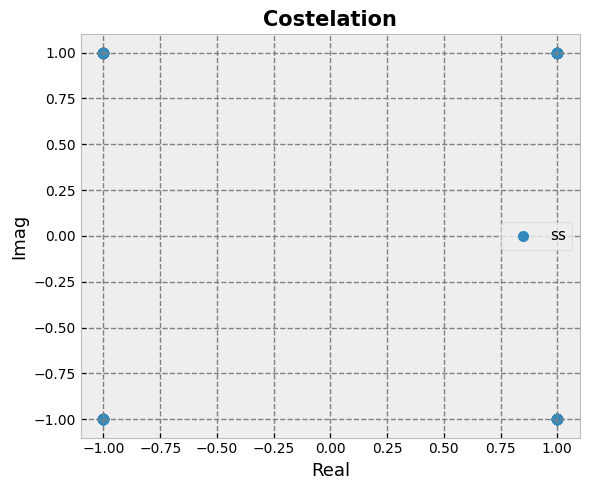

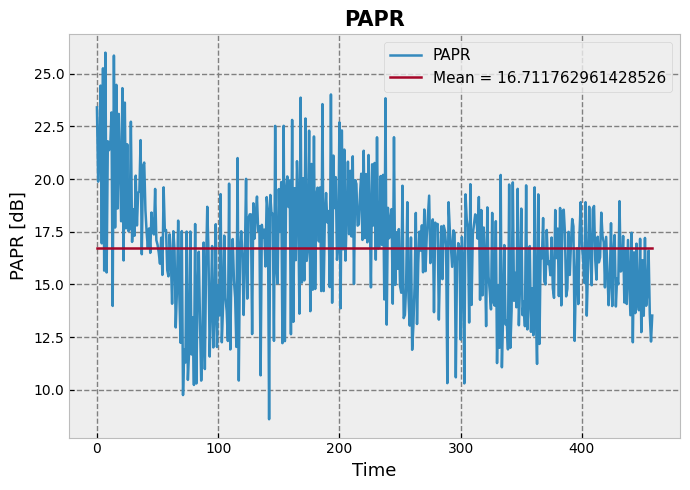

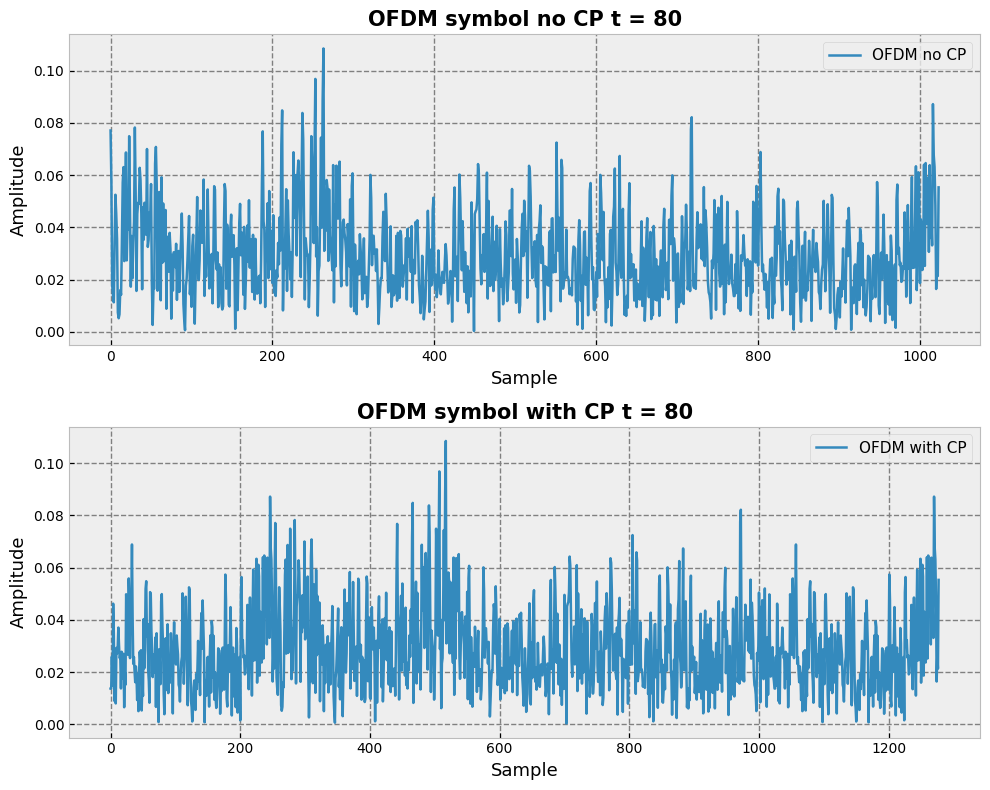

In [36]:
data_bits, image = imagen_grayscale_encoder(user_data_path)
a = modulator(data_bits, M)

# Serial to parallel and add pilots
a_with_pilots, pilot_positions = fill_subcarriers_with_pilots(a.copy(), Nc, pilot_value)

# OFDM modulation
a_padded = zeros_padding(a_with_pilots, N)
x = a_padded.copy()
for i in range(x.shape[0]):
    fft(x[i], inv=True)

# Add CP
x_cp = add_cp(x, Ncp)

# PAPR calculation
papr_values = cal_papr(x_cp)
mean_value = np.mean(papr_values)

# Plots
plot_one_figure(a.real, [a.imag], ["ss"], 'scatter', 'Costelation', 'Real', 'Imag', (6, 5))
plot_one_figure(np.arange(len(papr_values)), [papr_values, np.full(len(papr_values), mean_value)], ['PAPR', f'Mean = {mean_value}'], 'plot', 'PAPR', 'Time', 'PAPR [dB]', (7, 5))
plot_subplots(
    (2, 1), [np.arange(len(x[0])), np.arange(len(x_cp[0]))], [[np.abs(x[80])], [np.abs(x_cp[80])]], [['OFDM no CP'], ['OFDM with CP']], 'plot', ['OFDM symbol no CP t = 80', 'OFDM symbol with CP t = 80'], ['Sample']*2, ['Amplitude']*2, (10, 8)
)


### Channel 

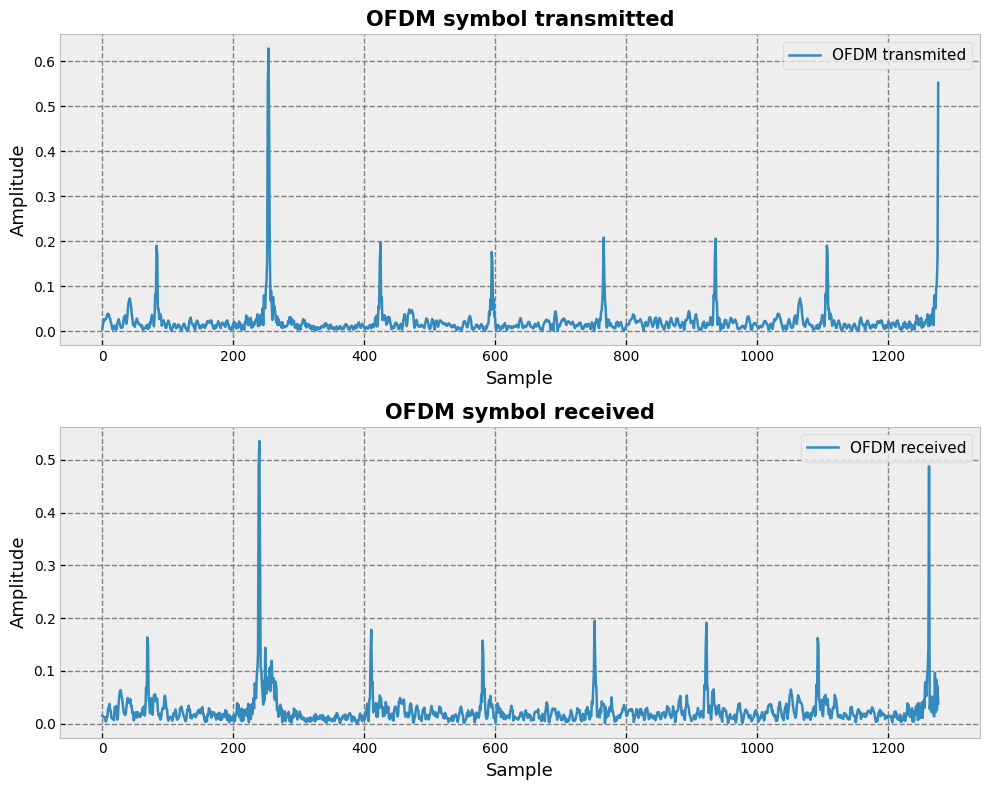

In [37]:
channel_response = generate_channel_response(num_paths, los_ratio)
r = channel(x_cp, channel_response, snr_db)

plot_subplots(
    (2, 1), [np.arange(N + Ncp), np.arange(N + Ncp)], [[np.abs(x_cp[0])], [np.abs(r[0])]], [['OFDM transmited'], ['OFDM received']], 'plot', ['OFDM symbol transmitted', 'OFDM symbol received'], ['Sample']*2, ['Amplitude']*2, (10, 8)
)

### Receiver

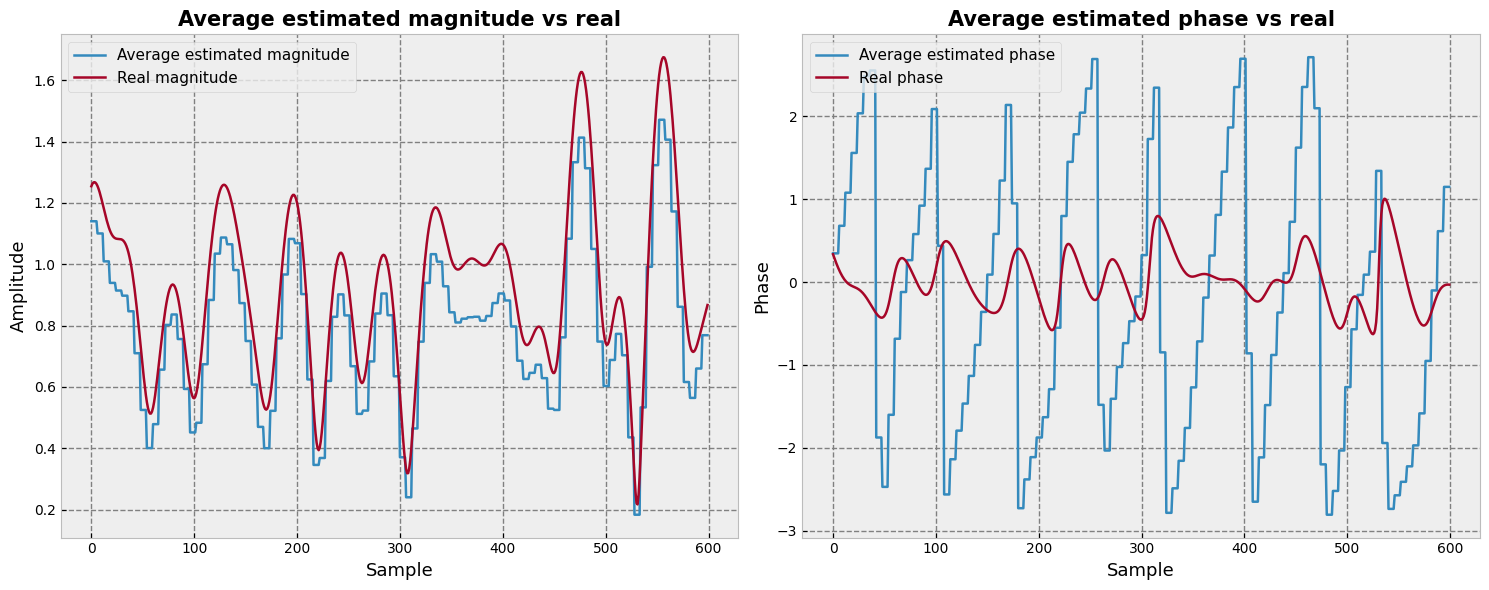

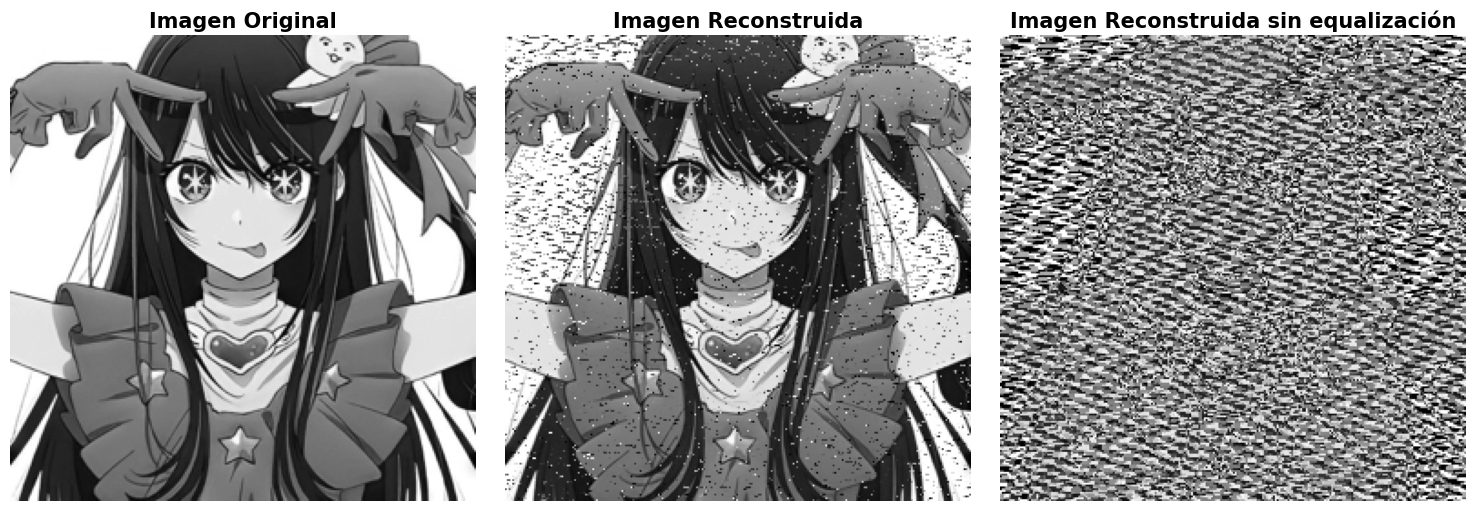

In [38]:
# Remove CP
r_no_cp = remove_cp(r, Ncp)

# OFDM demodulation
a_r = r_no_cp.copy()
for i in range(a_r.shape[0]):
    fft(a_r[i], inv=False)

# Channel estimation
H_est_matrix = estimate_channel(a_r, pilot_positions, pilot_value)

# Equalization
a_r_no_padding = a_r[:, :Nc]
equalized_signal = a_r_no_padding.copy() / H_est_matrix

# Delete pilots
ar_serial = delete_pilots(pilot_positions, equalized_signal, len(a))
ar_serial_no_eq = delete_pilots(pilot_positions, a_r_no_padding.copy(), len(a))

# Demodulation
data_bits_est = demodulator(ar_serial, M)
data_bits_no_eq = demodulator(ar_serial_no_eq, M)

image_est = np.packbits(data_bits_est).reshape(image.shape)
image_no_eq = np.packbits(data_bits_no_eq).reshape(image.shape)

# Channel estimation comparison
channel_response_f = np.pad(channel_response, (0, N - len(channel_response)), 'constant')
fft(channel_response_f, inv=False)

H_est_abs_avg = np.mean(np.abs(H_est_matrix), axis=0)
H_est_angle_avg = np.mean(np.angle(H_est_matrix), axis=0)

# Plots
plot_subplots(
    (1, 2), 
    [np.arange(len(H_est_abs_avg))]*2,  
    [
        [H_est_abs_avg, np.abs(channel_response_f)[:len(H_est_abs_avg)]],  # Magnitud promedio vs real
        [H_est_angle_avg, np.angle(channel_response_f)[:len(H_est_angle_avg)]]  # Fase promedio vs real
    ], 
    [["Average estimated magnitude", "Real magnitude"], ["Average estimated phase", "Real phase"]], 
    'plot', 
    ["Average estimated magnitude vs real", "Average estimated phase vs real"], 
    ["Sample"]*2, 
    ["Amplitude", "Phase"], 
    (15, 6)
)


plot_subplots(
    (1, 3), 
    ['']*3, 
    [image, image_est, image_no_eq], 
    [[], [], []], 
    'imshow', 
    ['Imagen Original', 'Imagen Reconstruida', 'Imagen Reconstruida sin equalización'], 
    ['']*3, 
    ['']*3, 
    (15, 5)
)
